# Property Valuation Model

In [1]:
# data engineering
import pandas as pd
import datetime
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LinearRegression,ElasticNet, Lasso, Ridge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier, VotingClassifier
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold,GridSearchCV,cross_val_score,learning_curve,StratifiedKFold,cross_val_predict,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error

#Hide Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Loading & Preview Datasets

In [2]:
#read raw data and preview top 5 rows
df=pd.read_csv(r'C:\Users\edward_chong1\Desktop\work_files\analysis\dataset.csv')
df.head()

,Application_Number,Disbursement_Manner,Submission_Mth,MG_OMV,MG_SnP,highest_MG_SnP_OMV,Free_Lease_Hold_Ind,Status_Of_Completion,Stage_Of_Completion,Title_Type,...,Land_Area,Land_Area_Unit,Property_Address,Postcode,Property_State,City_Nm,Property_Description,Property_Type,Residential_Type,Landed_Type
0,20114,PR,2018-03,364700.0,364700.0,364700.0,L,UC,0.0,M,...,0.0,NaN,"Block C (Cosmo),The Zizz @ Damansara North, Da...",47830,SELANGOR,Petaling Jaya,APARTMENT UNIT(S),Apartment,1. Residential,Non-Landed
1,80800,LS,2018-03,1452000.0,1102000.0,1452000.0,F,CO,100.0,I,...,220.0,F,"JALAN ADDA 6/16,TAMAN ADDA HEIGHTS",81100,JOHOR,Johor Bahru,"DOUBLE, SEMI-D HSE",Semi-Detached,1. Residential,Landed
2,38786,PR,2018-01,698000.0,698000.0,698000.0,L,UC,0.0,M,...,0.0,NaN,"Type B2,Parc 3 @ KL South",55300,W.P KUALA LUMPUR,Kuala Lumpur,APARTMENT UNIT(S),Apartment,1. Residential,Non-Landed
3,155116,LS,2019-12,190000.0,190000.0,190000.0,F,CO,100.0,S,...,0.0,NaN,"SOLOK SEMARAK API,BANDAR BARU AYER ITAM",11500,Pulau Pinang,AYER ITAM,Flat,Flat,1. Residential,Non-Landed
4,50826,PR,2017-07,600400.0,600400.0,600400.0,L,UC,50.0,M,...,0.0,NaN,"level no.6 of tower no.2 ,Vermont Suites Condo...",93350,SARAWAK,Kuching,CONDOMINIUM UNIT(S),Condominium,1. Residential,Non-Landed


In [3]:
#check for dtypes and missing values in dataframes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135766 entries, 0 to 135765
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Application_Number    135766 non-null  int64  
 1   Disbursement_Manner   135766 non-null  object 
 2   Submission_Mth        135766 non-null  object 
 3   MG_OMV                135766 non-null  float64
 4   MG_SnP                130578 non-null  float64
 5   highest_MG_SnP_OMV    135766 non-null  float64
 6   Free_Lease_Hold_Ind   135762 non-null  object 
 7   Status_Of_Completion  135766 non-null  object 
 8   Stage_Of_Completion   135759 non-null  float64
 9   Title_Type            135581 non-null  object 
 10  Build_Up_Area         134396 non-null  float64
 11  Build_Up_Area_Unit    91372 non-null   object 
 12  Land_Area             135766 non-null  float64
 13  Land_Area_Unit        69133 non-null   object 
 14  Property_Address      135761 non-null  object 
 15  

In [4]:
#compute percentage of missing values
df.isna().sum()/len(df)

Application_Number      0.000000
Disbursement_Manner     0.000000
Submission_Mth          0.000000
MG_OMV                  0.000000
MG_SnP                  0.038213
highest_MG_SnP_OMV      0.000000
Free_Lease_Hold_Ind     0.000029
Status_Of_Completion    0.000000
Stage_Of_Completion     0.000052
Title_Type              0.001363
Build_Up_Area           0.010091
Build_Up_Area_Unit      0.326989
Land_Area               0.000000
Land_Area_Unit          0.490793
Property_Address        0.000037
Postcode                0.000000
Property_State          0.000007
City_Nm                 0.000236
Property_Description    0.000000
Property_Type           0.000000
Residential_Type        0.000000
Landed_Type             0.000000
dtype: float64

In [5]:
#summarize numerical columns
df.describe()

,Application_Number,MG_OMV,MG_SnP,highest_MG_SnP_OMV,Stage_Of_Completion,Build_Up_Area,Land_Area
count,135766.000000,1.357660e+05,1.305780e+05,1.357660e+05,135759.00000,1.343960e+05,135766.000000
mean,90734.861151,4.167855e+05,5.672425e+05,5.733333e+05,62.81347,9.959073e+02,168.430148
std,53766.582357,5.224686e+05,5.132360e+05,5.326654e+05,43.70767,1.036639e+04,265.140886
min,1.000000,0.000000e+00,2.200000e+04,0.000000e+00,0.00000,0.000000e+00,0.000000
25%,44149.250000,5.700000e+04,3.020000e+05,3.088595e+05,10.00000,0.000000e+00,0.000000
50%,88959.500000,3.470000e+05,4.720000e+05,4.768000e+05,100.00000,8.580000e+02,80.040000
75%,137107.750000,5.630000e+05,6.609000e+05,6.630000e+05,100.00000,1.228000e+03,292.150000
max,186389.000000,2.980200e+07,4.800200e+07,4.800200e+07,100.00000,2.767168e+06,20979.020000


In [6]:
#summarize non-numerical columns
df.describe(include=['O'])

,Disbursement_Manner,Submission_Mth,Free_Lease_Hold_Ind,Status_Of_Completion,Title_Type,Build_Up_Area_Unit,Land_Area_Unit,Property_Address,Postcode,Property_State,City_Nm,Property_Description,Property_Type,Residential_Type,Landed_Type
count,135766,135766,135762,135766,135581,91372,69133,135761,135766,135765,135734,135766,135766,135766,135766
unique,2,36,3,2,3,1,1,74641,1212,30,939,97,13,2,2
top,LS,2019-05,F,CO,M,False,F,"Razak City Residences - Phase 1, 2 & 3",81300,Selangor,KUALA LUMPUR,APARTMENT UNIT(S),Terrace House,1. Residential,Landed
freq,74535,5346,92208,74159,62173,91372,69133,1192,4476,24078,13097,21533,55960,130399,70518


# Data Engineering & Handling Missing Values

In [7]:
#standardize upper and lower cases for city and state
df['Property_State']=df['Property_State'].str.upper()
df['City_Nm']=df['City_Nm'].str.upper()

#def function for postcode,state & city name cleanup
def process_postcode(postcode):
    if str(postcode)=='nan':
        return None
    try:
        x=int(postcode)
        if x==0:
            return None
        return x
    except:
        return None
    
def process_state_or_city(state_or_city):
    if str(state_or_city)=='nan':
        return None
    try:
        int(state_or_city)
        return None
    except:
        return str(state_or_city)

#apply function to process postcode,state & city
df['Postcode_processed']=df['Postcode'].apply(lambda x: process_postcode(x))
df['Property_State_processed']=df['Property_State'].apply(lambda x: process_state_or_city(x))
df['City_Nm_processed']=df['City_Nm'].apply(lambda x: process_state_or_city(x))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135766 entries, 0 to 135765
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Application_Number        135766 non-null  int64  
 1   Disbursement_Manner       135766 non-null  object 
 2   Submission_Mth            135766 non-null  object 
 3   MG_OMV                    135766 non-null  float64
 4   MG_SnP                    130578 non-null  float64
 5   highest_MG_SnP_OMV        135766 non-null  float64
 6   Free_Lease_Hold_Ind       135762 non-null  object 
 7   Status_Of_Completion      135766 non-null  object 
 8   Stage_Of_Completion       135759 non-null  float64
 9   Title_Type                135581 non-null  object 
 10  Build_Up_Area             134396 non-null  float64
 11  Build_Up_Area_Unit        91372 non-null   object 
 12  Land_Area                 135766 non-null  float64
 13  Land_Area_Unit            69133 non-null   o

In [9]:
#Property State only have 1 missing value. We manually look into this and estimate the corresponding City Name and Postcode
df.loc[(df['Property_State_processed'].isnull())]

,Application_Number,Disbursement_Manner,Submission_Mth,MG_OMV,MG_SnP,highest_MG_SnP_OMV,Free_Lease_Hold_Ind,Status_Of_Completion,Stage_Of_Completion,Title_Type,...,Postcode,Property_State,City_Nm,Property_Description,Property_Type,Residential_Type,Landed_Type,Postcode_processed,Property_State_processed,City_Nm_processed
33911,8249,LS,2018-04,247000.0,127000.0,247000.0,L,CO,100.0,M,...,47820,NaN,PETALING JAYA,APARTMENT UNIT(S),Apartment,1. Residential,Non-Landed,47820.0,None,PETALING JAYA


In [10]:
#This City is in Petaling Jaya. Hence, we can manually fill this as SELANGOR
df.loc[(df['Property_State_processed'].isnull()),'Property_State']='SELANGOR'
df['Property_State_processed'].fillna('SELANGOR',inplace=True)

In [11]:
# Now we have no missing values for Property State. We will use this to estimate the corresponding missing values for city name & postcode.
#We will estimate missing city names with mode occurance groupby Property_State & City Name
df_mode_city=df.groupby(['Property_State_processed','City_Nm_processed'], as_index=False).agg({'Application_Number':'count'})
df_mode_city.sort_values(by=['Application_Number'],ascending=[False],inplace=True)
df_mode_city.drop_duplicates(subset=['Property_State_processed'],keep='first',inplace=True)
df_mode_city=df_mode_city[['Property_State_processed','City_Nm_processed']]
df_mode_city.rename(columns={'City_Nm_processed':'City_Nm_estimated'},inplace=True)

#join estimated city column into main dataframe
df=pd.merge(df,df_mode_city,how='left',left_on=['Property_State_processed'],right_on=['Property_State_processed'])

In [12]:
#We will estimate missing postcode with mode occurance groupby City Name & Postcode
df_mode_postcode=df.groupby(['City_Nm_estimated','Postcode_processed'], as_index=False).agg({'Application_Number':'count'})
df_mode_postcode.sort_values(by=['Application_Number'],ascending=[False],inplace=True)
df_mode_postcode.drop_duplicates(subset=['City_Nm_estimated'],keep='first',inplace=True)
df_mode_postcode=df_mode_postcode[['City_Nm_estimated','Postcode_processed']]
df_mode_postcode.rename(columns={'Postcode_processed':'Postcode_estimated'},inplace=True)

#join estimated postcode column into main dataframe
df=pd.merge(df,df_mode_postcode,how='left',left_on=['City_Nm_estimated'],right_on=['City_Nm_estimated'])

In [13]:
#fill missing city and postcode with estimated values
df['City_Nm_processed'].fillna(df['City_Nm_estimated'],inplace=True)
df['Postcode_processed'].fillna(df['Postcode_estimated'],inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135766 entries, 0 to 135765
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Application_Number        135766 non-null  int64  
 1   Disbursement_Manner       135766 non-null  object 
 2   Submission_Mth            135766 non-null  object 
 3   MG_OMV                    135766 non-null  float64
 4   MG_SnP                    130578 non-null  float64
 5   highest_MG_SnP_OMV        135766 non-null  float64
 6   Free_Lease_Hold_Ind       135762 non-null  object 
 7   Status_Of_Completion      135766 non-null  object 
 8   Stage_Of_Completion       135759 non-null  float64
 9   Title_Type                135581 non-null  object 
 10  Build_Up_Area             134396 non-null  float64
 11  Build_Up_Area_Unit        91372 non-null   object 
 12  Land_Area                 135766 non-null  float64
 13  Land_Area_Unit            69133 non-null   o

In [15]:
#convert dtypes for postcode to int
df['Postcode_processed']=df['Postcode_processed'].astype(int)

In [16]:
#we have <1% of missing values in Free_Lease_Hold_Ind & Title Type , we can just use mode as our categorical estimation
df['Free_Lease_Hold_Ind'].fillna(df['Free_Lease_Hold_Ind'].mode()[0], inplace=True)
df['Title_Type'].fillna(df['Title_Type'].mode()[0], inplace=True)

#we have inconsistent data between completion status & stage of completion, we made an assumption that sometimes user only update one of the field.
#we overwrite CO status is <100% stage of completion to 100% and change the status of UC with 100% completion to CO
df.loc[(df['Status_Of_Completion']=='CO'),'Stage_Of_Completion']=100
df.loc[(df['Stage_Of_Completion']==100),'Status_Of_Completion']='CO'

#Mode of UC stage is 0%, hence we will fill the missing values under UC status as 0% completion
df['Stage_Of_Completion'].fillna(0,inplace=True)

# Feature Engineering

In [17]:
#we create a new feature which indicate submission_age from the existing Submission_Mth which is more representative and scalable when we pass it to the model
df['submission_year']=df['Submission_Mth'].apply(lambda x: x[:4]).astype(int)
df['submission_month']=df['Submission_Mth'].apply(lambda x: x[-2:]).astype(int)
df['submission_age']=(datetime.datetime.today().year-df['submission_year'])*12+(datetime.datetime.today().month-df['submission_month'])

In [18]:
# There are no missing values in MG_OMV column but there are values which are 0 i,e illogical. We will use MG_SnP to overwrite illogical values as our estimation.
df.loc[(df['MG_OMV']==0),'MG_OMV']=df['MG_SnP']

In [19]:
# generate a column as total build up area in sqft
df['Land_Area']=df['Land_Area']*10.764
df['total_build_up_area']=df[['Build_Up_Area', 'Land_Area']].max(axis=1)
df['total_build_up_area'].replace(0, np.nan, inplace=True)

In [20]:
#Further create another feature of price psf
df['price_psf']=df['MG_OMV']/df['total_build_up_area']

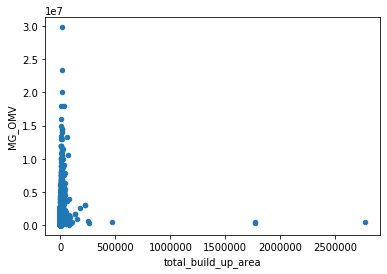

In [21]:
#we have small amount of outlier with extremely high psf/ extremely low psf
df.plot.scatter(x='total_build_up_area', y='MG_OMV')

In [22]:
#1st fillna with 0
df['price_psf'].fillna(0,inplace=True)

#Using z-score to remove the outliers (2 standard deviations above the mean)
df['z_score'] = (df['price_psf'] - df['price_psf'].mean())/df['price_psf'].std(ddof=0)
old_len=len(df)
df = df.loc[df['z_score'].abs()<=2]
new_len=len(df)

o_rows = old_len - new_len
print('number of outlier rows removed: {}'.format(o_rows))

number of outlier rows removed: 5


In [23]:
#find average price psf by city as an estimation for missing price psf
avg_price_by_city=df.loc[(df['price_psf']>0)]
avg_price_by_city=avg_price_by_city.groupby(['City_Nm_processed'], as_index=False).agg({'price_psf':'mean'})
avg_price_by_city.rename(columns={'price_psf':'price_psf_estimated'},inplace=True)
#join estimated city column into main dataframe
df=pd.merge(df,avg_price_by_city,how='left',left_on=['City_Nm_processed'],right_on=['City_Nm_processed'])

#fill missing values of price psf with price_psf_estimated
df.loc[df['price_psf']==0,'price_psf']=df['price_psf_estimated']

#let's see how many missing values we failed to get rid of by using the city estimation approach
df['price_psf'].isna().sum()

2

In [24]:
#we use a bigger cluster for further estimation of the 2 values we failed to get rid of using city estimation
avg_price_by_state=df.loc[(df['price_psf']>0)]
avg_price_by_state=avg_price_by_state.groupby(['Property_State_processed'], as_index=False).agg({'price_psf':'mean'})
avg_price_by_state.rename(columns={'price_psf':'price_psf_estimated2'},inplace=True)
#join estimated city column into main dataframe
df=pd.merge(df,avg_price_by_state,how='left',left_on=['Property_State_processed'],right_on=['Property_State_processed'])

#fill missing values of price psf with price_psf_estimated
df['price_psf'].fillna(df['price_psf_estimated2'],inplace=True)

In [25]:
# now we have all price psf for every property records, so we estimated total build up missing values base on MG_OMV/price_psf
df.loc[df['total_build_up_area'].isnull(),'total_build_up_area']=df['MG_OMV']/df['price_psf']

# estimate missing MG OMV using price_psf*total_build_up_area
df.loc[df['MG_OMV'].isnull(),'MG_OMV']=df['price_psf']*df['total_build_up_area']

In [26]:
#Select features and target columns 
main=df[['Disbursement_Manner','submission_age','MG_OMV','price_psf','Free_Lease_Hold_Ind','Status_Of_Completion','Stage_Of_Completion','Title_Type','total_build_up_area','Property_Type','Residential_Type','Landed_Type','Postcode_processed','Property_State_processed','City_Nm_processed']]

In [27]:
#check any missing values on features column
main.isna().sum()

Disbursement_Manner         0
submission_age              0
MG_OMV                      0
price_psf                   0
Free_Lease_Hold_Ind         0
Status_Of_Completion        0
Stage_Of_Completion         0
Title_Type                  0
total_build_up_area         0
Property_Type               0
Residential_Type            0
Landed_Type                 0
Postcode_processed          0
Property_State_processed    0
City_Nm_processed           0
dtype: int64

# Feature Analysis & Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002225A016288>,
      dtype=object)

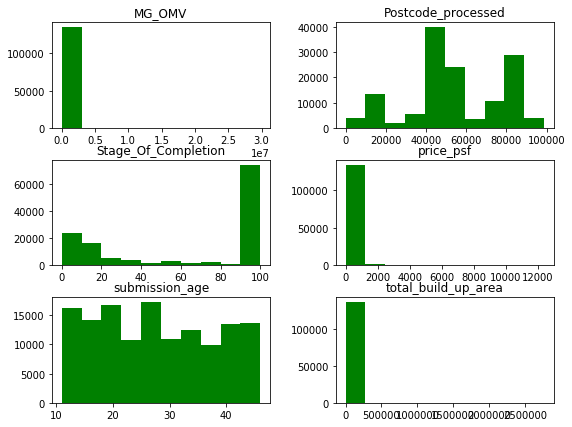

In [28]:
# preview distribution of non categorical features
main.hist(bins=10,figsize=(9,7),grid=False,color='green')

In [29]:
numeric_feats = main.dtypes[main.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = main[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness


Skew in numerical features: 



,Skew
total_build_up_area,200.617743
MG_OMV,9.010440
price_psf,3.950595
submission_age,0.150573
Postcode_processed,-0.217474
Stage_Of_Completion,-0.449567


# Box Cox Transformation of (highly) skewed features

In [30]:
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feature in skewed_features:
    main[feature] = boxcox1p(main[feature], lam)

There are 3 skewed numerical features to Box Cox transform


# Categorical Encoding

In [31]:
cat_features=['Disbursement_Manner','Free_Lease_Hold_Ind','Status_Of_Completion','Title_Type','Property_Type','Residential_Type','Landed_Type','Postcode_processed','Property_State_processed','City_Nm_processed']
for cat_feature in cat_features:
    main[cat_feature]=main[cat_feature].astype('category')
    main[cat_feature]=main[cat_feature].cat.codes

# Splitting data into train and test 

In [32]:
train,test=train_test_split(main, test_size=0.2,random_state=42)

In [33]:
y_train = train['MG_OMV'].values
X_train= train.drop(columns=['MG_OMV']).values

#verify shape of training data
print(y_train.shape,X_train.shape)

(108608,) (108608, 14)


In [34]:
y_test = test['MG_OMV'].values
X_test= test.drop(columns=['MG_OMV']).values

#verify shape of testing data
print(y_test.shape,X_test.shape)

(27153,) (27153, 14)


In [35]:
#Analyzing Target - MG_OMV


 mu = 40.63 and sigma = 4.61



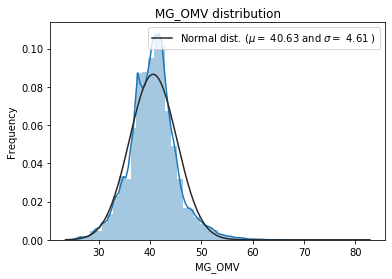

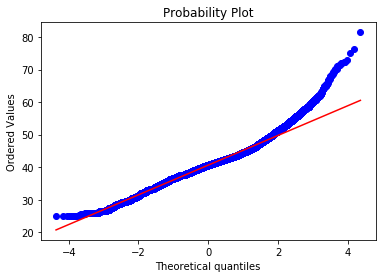

In [36]:
sns.distplot(train['MG_OMV'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['MG_OMV'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MG_OMV distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['MG_OMV'], plot=plt)
plt.show()

In [37]:
#We conclude that the target is skewed to the right

# Log-transformation of the target variable


 mu = 3.72 and sigma = 0.11



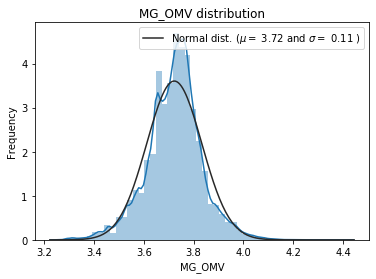

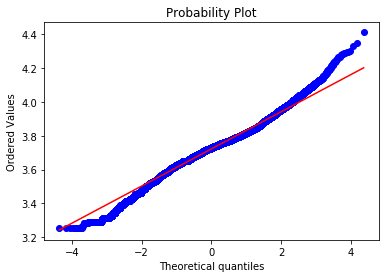

In [38]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["MG_OMV"] = np.log1p(train["MG_OMV"])

#Check the new distribution 
sns.distplot(train['MG_OMV'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['MG_OMV'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MG_OMV distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['MG_OMV'], plot=plt)
plt.show()

# Modeling

In [39]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# LASSO Regression
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [40]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))

# Elastic Net Regression
again made robust to outliers

In [41]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=42))

# Ridge Regression

In [42]:
Ridge = Ridge(random_state=42)

# Linear Regression

In [43]:
lin_reg = LinearRegression(normalize=True)

# Gradient Boosting Regression
With huber loss that makes it robust to outliers

In [44]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# XGBoost

In [45]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =42, nthread = -1)

# LightGBM

In [46]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 10, feature_fraction = 0.23,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6)

# Base models scores

In [47]:
models=[lasso,ENet,Ridge,lin_reg,GBoost,model_xgb,model_lgb]
models_name=['lasso','ENet','Ridge','lin_reg','GBoost','model_xgb','model_lgb']
for i,model in enumerate(models):
    score = rmsle_cv(model)
    print("\n{} score: {:.4f} ({:.4f})\n".format(models_name[i],score.mean(), score.std()))


lasso score: 0.0161 (0.0017)


ENet score: 0.0160 (0.0017)


Ridge score: 0.0157 (0.0017)


lin_reg score: 0.0157 (0.0017)


GBoost score: 0.0048 (0.0004)


model_xgb score: 0.0099 (0.0003)

[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current 

# Stacking Models
Stacking approach : Averaging base model

In [48]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1) 

In [49]:
averaged_models = AveragingModels(models = (lasso, ENet, GBoost, lin_reg))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0120 (0.0013)



# 2nd Stacking Approach: Adding a Meta-model
In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

Split the total training set into two disjoint sets (here train and .holdout )

Train several base models on the first part (train)

Test these base models on the second part (holdout)

Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

In [50]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [59]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, lin_reg, GBoost), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0042 (0.0005)


# Ensembling StackedRegressor, XGBoost and LightGBM
We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function

In [52]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# StackedRegressor

In [60]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test))
print(rmsle(y_train, stacked_train_pred))

0.0036492219600697323


# XGBoost

In [61]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.008964195851545745


# LightGBM

In [62]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.23, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
0.016726161387864216


In [63]:
#RMSE on the entire Train data when averaging
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70+xgb_train_pred*0.15 +lgb_train_pred*0.15 ))

RMSLE score on train data:
0.005024851478526308


# Ensembling & Final Prediction

In [64]:
ensemble=stacked_pred*0.70+xgb_pred*0.15+lgb_pred*0.15

# y_test Prediction RMSE & Results output

In [65]:
print(rmsle(y_test,ensemble))

output = pd.DataFrame()
output['y_test'] = y_test
output['prediction'] = ensemble
output.to_csv(r'C:\Users\edward_chong1\Desktop\work_files\analysis\output.csv',index=False)

0.2319998858837698
